In [22]:
from torchvision.utils import save_image
import time
from matplotlib import pyplot as plt
from pathlib import Path
import torch
from torchmetrics import SSIM, PSNR, MeanSquaredError

from loader import loader

from models.CSA import CSA
from tools.toml import load_option
from plot import array2image

def mkdir(out_dir):
    out_dir = Path(out_dir)
    if not out_dir.exists():
        out_dir.mkdir(parents=True, exist_ok=True)

def mask_op(mask):
    mask = mask.cuda()
    mask = mask[0][0]
    mask = torch.unsqueeze(mask, 0)
    mask = torch.unsqueeze(mask, 1)
    mask = mask.byte()
    return mask

In [2]:
alpha = 1
beta = 1
valset = loader.valset(alpha)
maskset = loader.maskset
print('数据集数量：', len(valset))
print('掩码数量：', len(maskset))

数据集数量： 19867
掩码数量： 12000


In [3]:
model_name = 'CSA'

base_opt = load_option('options/base.toml')
opt = load_option('options/train.toml')
opt.update(base_opt)
opt.update({'name': model_name}) # 设定模型名称
model = CSA(beta, **opt)

image_save_dir = model.save_dir / 'images'
mkdir(image_save_dir)

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
UnetGeneratorCSA(
  (model): UnetSkipConnectionBlock_3(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): UnetSkipConnectionBlock_3(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
          (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (6): UnetSkipConnectionBlock_3(
            (model): Sequential(
              (0): LeakyReLU(negat

In [4]:
load_name = "1-1"
model.load(load_name)

In [5]:
save_dir = f'../measure/{model_name}'

epoch = 1
i = 0
total_steps = 0
for batch, mask in zip(valset, maskset):
    iter_start_time = time.time()
    image = batch[0]
    image = image.cuda()
    mask = mask_op(mask)
    model.set_input(image, mask)
    model.set_gt_latent()
    model.test()
    real_A, real_B, fake_B = model.get_current_visuals()
    total_steps += model.batch_size
    pic = (torch.cat([real_A, real_B, fake_B], dim=0) + 1) / 2.0
    save_image(pic, f"{save_dir}/epoch{epoch}-{total_steps}.jpg", nrow=1)
    break

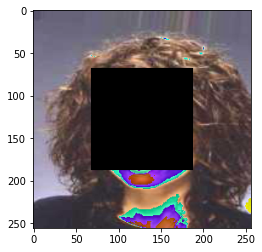

In [6]:
x = array2image(real_A[0])
plt.imshow(x);

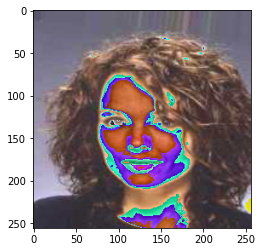

In [7]:
x = array2image(real_B[0])
plt.imshow(x);

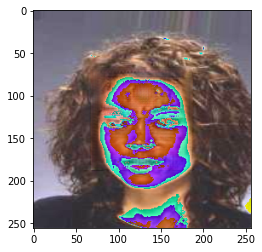

In [8]:
x = array2image(fake_B[0])
plt.imshow(x);

In [16]:
ssim = SSIM()
ssim(fake_B, real_B)

C:\Users\xinet\anaconda3\envs\torch\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor(0.8534, device='cuda:0')

In [20]:
psnr = PSNR()
psnr(fake_B.cpu(), real_B.cpu())

tensor(21.9598)

In [24]:
mse = MeanSquaredError()
mse(fake_B.cpu(), real_B.cpu())

tensor(1592.0503)